In [4]:
import sys
sys.path.insert(0,'..')
import random
input_dir = "../../data/semantic-segmentation/cityscapes/leftImg8bit_trainvaltest/leftImg8bit/train" #CHANGE THE PATHS!!!
target_dir = "../../data/semantic-segmentation/cityscapes/gtFine_trainvaltest/gtFine/train" #CHANGE THE PATHS!!!
img_size = (160, 160)
num_classes = 20
batch_size = 16
from dataloaders.cityscapes.cityscapes import Cityscapes,get_img_paths
input_img_paths,target_img_paths = get_img_paths(input_dir,target_dir)
print("Number of samples:", len(input_img_paths))   
# Split our img paths into a training and a validation set
val_samples = 200
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]


CITY = Cityscapes(
      batch_size, img_size, train_input_img_paths, train_target_img_paths
  )

Number of samples: 2975


In [5]:
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
import time

NUM_SPLITS = 10

LBL_CL_DICT = dict()
def count_class(lbl_path,cl,img_size):
    if(lbl_path not in LBL_CL_DICT.keys()):
        img = load_img(lbl_path, target_size=img_size, color_mode="grayscale")
        lbl_map = np.array(img)
        lbl_map = CITY.fix_indxs(lbl_map)
        counts = np.unique(lbl_map, return_counts=True)
        counts_dict = dict(zip(counts[0],counts[1]))
        LBL_CL_DICT[lbl_path] = counts_dict
    else:
        counts_dict = LBL_CL_DICT[lbl_path]
    if(int(cl) in counts_dict.keys()):
        return counts_dict[int(cl)]
    else:
        return 0

ds_table = pd.DataFrame(list(zip(train_input_img_paths, train_target_img_paths)),
               columns =['Image', 'Target'])
backup_table = ds_table.copy()
for cl in range(num_classes):
    ds_table[str(cl)] = ds_table.apply(lambda row: count_class(row[1],cl,img_size), axis=1)
    

splits = [set() for _ in range(NUM_SPLITS)]
for _ in range(int(len(backup_table) / (NUM_SPLITS+len(ds_table.columns[2:])))):
    for i_split in range(NUM_SPLITS):
        split = set()
        for col in ds_table.columns[2:]:
            if(len(ds_table)>0):
                rec_id = ds_table[ds_table[col] == ds_table[col].max()].index[0]
                split.add(rec_id)
                ds_table = ds_table.drop(rec_id)
            if(len(ds_table==0)):
                continue
                rec_id = ds_table[ds_table[col] == ds_table[col].min()].index[0]
                split.add(rec_id)
                ds_table = ds_table.drop(rec_id)

        splits[i_split] = splits[i_split].union(split)

In [3]:
ds_table

,Image,Target,0,1,2,3,4,5,6,7,...,10,11,12,13,14,15,16,17,18,19


In [4]:
ds_table.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
max,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
backup_table.loc[splits[0]]

,Image,Target
2055,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...
2058,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...
10,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...
14,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...
2068,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...
...,...,...
2019,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...
2029,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...
1012,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...
1017,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...


In [6]:
# backup_table['Image'].loc[splits[0]].tolist()

In [7]:
ds_table = backup_table.copy()

In [8]:
NUM_SPLITS = 10

splits = [set() for _ in range(NUM_SPLITS)]
for _ in range(int(len(backup_table) / (NUM_SPLITS+len(ds_table.columns[2:])))):
    for i_split in range(NUM_SPLITS):
        split = set()
        for col in ds_table.columns[2:]:
            if(len(ds_table)>0):
                rec_id = ds_table[ds_table[col] == ds_table[col].max()].index[0]
                split.add(rec_id)
                ds_table = ds_table.drop(rec_id)
            if(len(ds_table==0)):
                continue
                rec_id = ds_table[ds_table[col] == ds_table[col].min()].index[0]
                split.add(rec_id)
                ds_table = ds_table.drop(rec_id)

        splits[i_split] = splits[i_split].union(split)
#     ds_table.drop(ds_table[ds_table['0'] == ds_table['0'].max()].index).describe()

In [9]:
len(ds_table==0)

2775

In [ ]:
len(splits[1])

In [8]:
backup_table.loc[splits[0]].describe()

,Image,Target
count,0,0
unique,0,0
top,NaN,NaN
freq,NaN,NaN


In [9]:
from dataloaders.cityscapes.city_pss import City_PSS

In [10]:
input_dir = "../../data/semantic-segmentation/cityscapes/leftImg8bit_trainvaltest/leftImg8bit/train" #CHANGE THE PATHS!!!
target_dir = "../../data/semantic-segmentation/cityscapes/gtFine_trainvaltest/gtFine/train" #CHANGE THE PATHS!!!
img_size = (160, 160)
num_classes = 20
batch_size = 16
NUM_SPLITS = 10

In [11]:
city_pss = City_PSS(input_dir,target_dir,img_size,num_classes,batch_size,NUM_SPLITS)

Number of samples: 2975


In [10]:
train_gens = city_pss.getSplits()

In [5]:
train_gens

In [15]:
city_pss.backup_table

,Image,Target
0,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...
1,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...
2,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...
3,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...
4,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...
...,...,...
2770,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...
2771,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...
2772,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...
2773,../data/semantic-segmentation/cityscapes/leftI...,../data/semantic-segmentation/cityscapes/gtFin...


In [12]:
ds_table = city_pss.backup_table.copy()

In [13]:
for cl in range(num_classes):
    ds_table[str(cl)] = ds_table.apply(lambda row: city_pss.count_class(row[1],cl,img_size), axis=1)

In [14]:
# ds_table.describe().loc[['mean','std','min','max']].plot(kind='box', figsize=[16,8], ylim=(0,18000))
data1 = ds_table.describe().loc[['mean','std','min','max']].assign(Location='Original')
data2 = ds_table[ds_table.index.isin(list(city_pss.splits[0]))].describe().loc[['mean','std','min','max']].assign(Location='Split 1')
data3 = ds_table[ds_table.index.isin(list(city_pss.splits[1]))].describe().loc[['mean','std','min','max']].assign(Location='Split 2')
data4 = ds_table[ds_table.index.isin(list(city_pss.splits[9]))].describe().loc[['mean','std','min','max']].assign(Location='Split 10')

In [15]:
# ds_table[ds_table.index.isin(list(city_pss.splits[0]))].describe().loc[['mean','std','min','max']].plot(kind='box', figsize=[16,8], ylim=(0,18000))

In [16]:
# ds_table[ds_table.index.isin(list(city_pss.splits[9]))].describe().loc[['mean','std','min','max']].plot(kind='box', figsize=[16,8], ylim=(0,18000))

In [37]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

   Location class         value
0  Original     0   8379.220901
1  Original     0   1965.424293
2  Original     0      0.000000
3  Original     0  13047.000000
4   Split 1     0   8240.614286


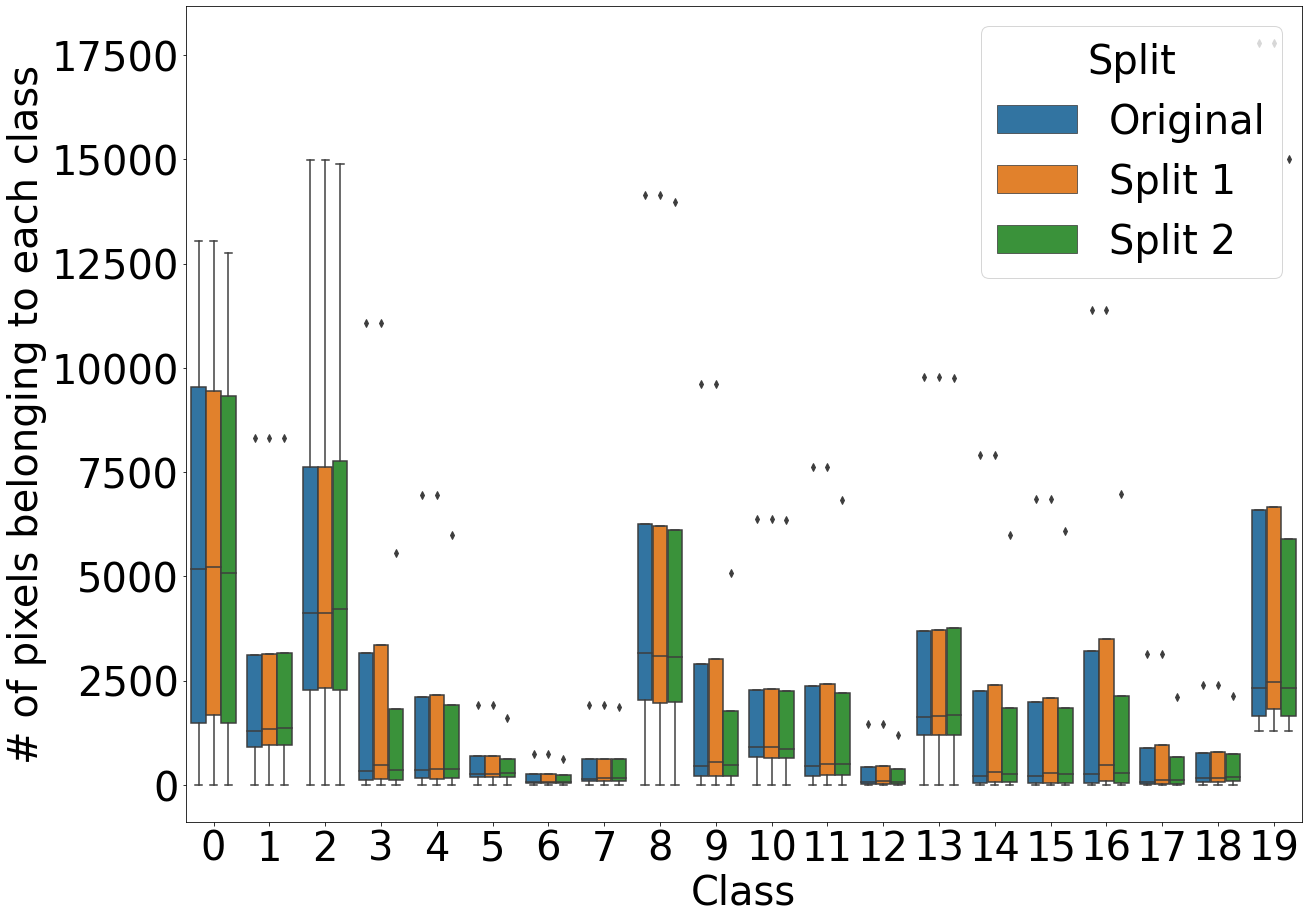

In [39]:
cdf = pd.concat([data1, data2, data3])    
mdf = pd.melt(cdf, id_vars=['Location'], var_name=['class'])
print(mdf.head())
mdf = mdf.rename(columns={"Location": "Split"})
ax = sns.boxplot(x="class", y="value", hue="Split", data=mdf)  
# params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (15, 5),
#          'axes.labelsize': 'x-large',
#          'axes.titlesize':'x-large',
#          'xtick.labelsize':'x-large',
#          'ytick.labelsize':'x-large'}
# plt.rcParams = params

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 42}

plt.rcParams['font.size']= 40
plt.rcParams['figure.figsize'] =  20, 15
plt.xlabel('Class')
plt.ylabel('# of pixels belonging to each class')

# plt.rcParams['dpi']= 210
plt.savefig('fig-pss-splits.png',bbox_inches='tight')

   Location Letter     value
0         1      A  0.986161
1         1      A  0.778196
2         1      A  0.988858
3         1      A  0.412573
4         1      A  0.364292


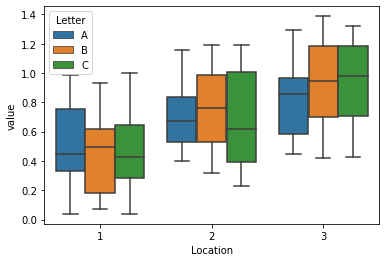

In [136]:
data1 = pd.DataFrame(np.random.rand(17,3), columns=['A','B','C']).assign(Location=1)
data2 = pd.DataFrame(np.random.rand(17,3)+0.2, columns=['A','B','C']).assign(Location=2)
data3 = pd.DataFrame(np.random.rand(17,3)+0.4, columns=['A','B','C']).assign(Location=3)

cdf = pd.concat([data1, data2, data3])    
mdf = pd.melt(cdf, id_vars=['Location'], var_name=['Letter'])
print(mdf.head())

#    Location Letter     value
# 0         1      A  0.223565
# 1         1      A  0.515797
# 2         1      A  0.377588
# 3         1      A  0.687614
# 4         1      A  0.094116

ax = sns.boxplot(x="Location", y="value", hue="Letter", data=mdf)    
plt.show()